In [1]:
import os
import re
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import scorpyo as sp

from null_importance import get_null_importance


pd.set_option('max_rows', 500, 'max_columns', 200)

In [2]:
path_project = r'/Users/liliangshan/workspace/python/01_datasets/ccf_system_access_risk_identification'

# path dir
path_row_data = os.path.join(path_project, 'row_data')
path_new_data = os.path.join(path_project, 'new_data')
path_results  = os.path.join(path_project, 'results')
path_results_jupyter  = os.path.join(path_results, 'jupyter')

# path row_data
path_train = os.path.join(path_row_data, 'train.csv')
path_test  = os.path.join(path_row_data, 'evaluation_public.csv')
path_sample_submission = os.path.join(path_row_data, 'submit_example.csv')


path_new_train = os.path.join(path_new_data, 'train_lightgbm_20221014.csv')
path_new_test  = os.path.join(path_new_data, 'test_lightgbm_20221014.csv')

## results
path_output_report = os.path.join(path_results, '01_原始数据探察_20221014.xlsx')

y_label = "is_risk"

In [3]:
df_row_train = sp.read_data(path_train)
df_row_val  = sp.read_data(path_test)

df_row_train['url_sit'] = df_row_train['url'].map(lambda x: x.split('/')[0])
df_row_train['url_page'] = df_row_train['url'].map(lambda x: x.split('/')[1])

df_row_val['url_sit'] = df_row_val['url'].map(lambda x: x.split('/')[0])
df_row_val['url_page'] = df_row_val['url'].map(lambda x: x.split('/')[1])



df_train_info = df_row_train.copy().sort_values(by='op_datetime')

## 定义一次/一天/一月
1. op\_times\_groups 一次
2. op\_days 一天
3. op\_month 一月

In [4]:
df = pd.concat([df_row_train, df_row_val]).reset_index(drop=True)
df = df.sort_values(by='op_datetime')

# 认证日期时间
df['op_datetime'] = pd.to_datetime(df['op_datetime'])
# 将数据分为每一天
df['op_days'] = df['op_datetime'].map(lambda x: x.strftime('%Y-%m-%d'))

# 按客户进行统计这次认证和上次认证的时间差
df['op_second'] = df['op_datetime']
df['op_second1'] = df.groupby('device_num_transform')['op_second'].shift(1)
df['op_diff_second1'] = (df['op_second'] - df['op_second1']).map(lambda x: x.total_seconds())
df['op_diff_second1_tmp'] = df['op_diff_second1']>10
# 客户第几次登录
df['op_times_groups'] = df.groupby('device_num_transform')['op_diff_second1_tmp'].apply(lambda x: x.cumsum())

# 系统层面的一段时间
df['system_op_second'] = df['op_datetime']
df['system_op_second1'] = df['system_op_second'].shift(1)
df['system_op_diff_second1'] = (df['system_op_second'] - df['system_op_second1']).map(lambda x: x.total_seconds())
df['system_op_diff_second1_tmp'] = df['system_op_diff_second1']>400
# 客户第几次登录
df['system_op_times_groups'] = df['system_op_diff_second1_tmp'].cumsum()

df = df.drop(columns=['op_second','op_second1','op_diff_second1_tmp', 
                      'system_op_second', 'system_op_second1', 'system_op_diff_second1_tmp'])

## 环境特征

In [5]:

time_feats = ['system_op_times_groups', 'op_days', 'op_month']

cate_feats = ['ip_transform', 'user_name', 'device_num_transform', 'department', 'browser_version', 'browser', 'os_type','os_version',
              'ip_type','http_status_code', 'op_city', 'log_system_transform', 'url', 'url_page','url_sit']

# 客户+时间+按时间cumsum/cumunique
# 累计量统计
df['helper'] = 1
# 是否为异常状态码
df['http_status_code_helper'] = df['http_status_code'].map(lambda x: 1 if x in [400, 500, 502, 404] else 0) 
# 给样本编号
df['sampler_index_helper'] = df['helper'].cumsum()

for i in time_feats:
    i_tmp = df.groupby([i])
    # 系统往前看，处理了多少事
    df['system_{}_cumsum'.format(i)] = i_tmp['helper'].cumsum()
    # 系统往前看，处理了多少坏事
    df['system_{}_error_code_cumsum'.format(i)] = i_tmp['http_status_code_helper'].cumsum()
    for j in cate_feats:
        index_set = set(df.groupby([i, j],as_index=False).first()['sampler_index_helper'].values)
        df['tmp_helper'] = df['sampler_index_helper'].map(lambda x: 1 if x in index_set else 0)
        # 系统往前看，不同维度的处理了多少情况
        df['system_{}_{}_cumunique'.format(i, j)] = df.groupby([i, j])['tmp_helper'].cumsum()
        
        if j not in ['ip_transform', 'user_name', 'device_num_transform']:
            for k in df[j].unique():
                tmp = df[df[j]==k].groupby([i])

                # 系统往前看，不同维度不同情况分别处理了多少次
                df['system_{}_{}_{}_cumsum'.format(i,j,k)] = tmp['helper'].cumsum()
                # 系统往前看，不同维度不同情况error_code分别处理了多少次
                df['system_{}_{}_{}_error_code_cumsum'.format(i,j,k)] = tmp['http_status_code_helper'].cumsum()

remove_cols = [x for x in df.columns if x[-6:]=='helper']

df = df.drop(columns=remove_cols)


## 对象层面

In [6]:

time_feats = ['op_times_groups', 'op_days', 'op_month']

object_feats = ['ip_transform', 'user_name', 'device_num_transform']

cate_feats = ['ip_transform', 'user_name', 'device_num_transform', 'department', 'browser_version', 'browser', 'os_type','os_version',
              'ip_type','http_status_code', 'op_city', 'log_system_transform', 'url', 'url_page','url_sit']

# 客户+时间+按时间cumsum/cumunique
# 累计量统计
df['helper'] = 1
# 是否为异常状态码
df['http_status_code_helper'] = df['http_status_code'].map(lambda x: 1 if x in [400, 500, 502, 404] else 0) 
# 给样本编号
df['sampler_index_helper'] = df['helper'].cumsum()


for i in time_feats:
    for j in object_feats:
        j_tmp = df.groupby([i,j])
        df['{}_{}_cumsum'.format(i,j)] = j_tmp['helper'].cumsum()
        df['{}_{}_error_code_cumsum'.format(i,j)] = j_tmp['http_status_code_helper'].cumsum()
        for k in cate_feats:
            if k == j: continue
            index_set = set(df.groupby([i,j,k], as_index=False).first()['sampler_index_helper'].values)            
            df['tmp_helper'] = df['sampler_index_helper'].map(lambda x: 1 if x in index_set else 0)
            df['{}_{}_{}_cumunique'.format(i,j,k)] = df.groupby([i,j,k])['tmp_helper'].cumsum()
            
            if j not in ['ip_transform', 'user_name', 'device_num_transform']:
                for v in df[k].unique():
                    v_tmp = df[df[k]==v].groupby([i,j])
                    df['{}_{}_{}_{}_cumsum'.format(i,j,k,v)] = v_tmp['helper'].cumsum()
                    df['{}_{}_{}_{}_error_code_cumsum'.format(i,j,k,v)] = v_tmp['http_status_code_helper'].cumsum()

remove_cols = [x for x in df.columns if x[-6:]=='helper']

df = df.drop(columns=remove_cols)

## 其它操作

In [7]:
# 几点钟
df['hour'] = df['op_datetime'].dt.hour
df['hour_sin'] = np.sin(df['hour']/24*2*np.pi)
df['hour_cos'] = np.cos(df['hour']/24*2*np.pi)

# 周几
df['dayofweek'] = df['op_datetime'].dt.dayofweek
df['dayofweek_sin'] = np.sin(df['dayofweek']/7*2*np.pi)
df['dayofweek_cos'] = np.cos(df['dayofweek']/7*2*np.pi)

# 一个月的第几天
df['day'] = df['op_datetime'].dt.day
df['day_sin'] = np.sin(df['day']/31*2*np.pi)
df['day_cos'] = np.cos(df['day']/31*2*np.pi)

## 特征筛选

In [8]:
# 删除时间及类别型变量过多的特征
remove_col = ['op_datetime', 'op_month', 'user_name', 'ip_transform', 'device_num_transform', 'op_days', 'ts', 'ts1', 'ts2','ts3']

remove_col = [x for x in df.columns if x in remove_col]
df = df.drop(columns=remove_col)
df.head()

,id,department,browser_version,browser,os_type,os_version,ip_type,http_status_code,op_city,log_system_transform,url,is_risk,url_sit,url_page,op_diff_second1,op_times_groups,system_op_diff_second1,system_op_times_groups,system_system_op_times_groups_cumsum,system_system_op_times_groups_error_code_cumsum,system_system_op_times_groups_ip_transform_cumunique,system_system_op_times_groups_user_name_cumunique,system_system_op_times_groups_device_num_transform_cumunique,system_system_op_times_groups_department_cumunique,system_system_op_times_groups_department_rd_cumsum,system_system_op_times_groups_department_rd_error_code_cumsum,system_system_op_times_groups_department_hr_cumsum,system_system_op_times_groups_department_hr_error_code_cumsum,system_system_op_times_groups_department_sales_cumsum,system_system_op_times_groups_department_sales_error_code_cumsum,system_system_op_times_groups_department_other_cumsum,system_system_op_times_groups_department_other_error_code_cumsum,system_system_op_times_groups_department_nan_cumsum,system_system_op_times_groups_department_nan_error_code_cumsum,system_system_op_times_groups_department_accounting_cumsum,system_system_op_times_groups_department_accounting_error_code_cumsum,system_system_op_times_groups_browser_version_cumunique,system_system_op_times_groups_browser_version_chrome_93_cumsum,system_system_op_times_groups_browser_version_chrome_93_error_code_cumsum,system_system_op_times_groups_browser_version_safari_13_cumsum,system_system_op_times_groups_browser_version_safari_13_error_code_cumsum,system_system_op_times_groups_browser_version_firefox_78_cumsum,system_system_op_times_groups_browser_version_firefox_78_error_code_cumsum,system_system_op_times_groups_browser_version_edge_93_cumsum,system_system_op_times_groups_browser_version_edge_93_error_code_cumsum,system_system_op_times_groups_browser_version_ie_9_cumsum,system_system_op_times_groups_browser_version_ie_9_error_code_cumsum,system_system_op_times_groups_browser_version_chrome_77_cumsum,system_system_op_times_groups_browser_version_chrome_77_error_code_cumsum,system_system_op_times_groups_browser_version_chrome_90_cumsum,system_system_op_times_groups_browser_version_chrome_90_error_code_cumsum,system_system_op_times_groups_browser_version_ie_11_cumsum,system_system_op_times_groups_browser_version_ie_11_error_code_cumsum,system_system_op_times_groups_browser_cumunique,system_system_op_times_groups_browser_chrome_cumsum,system_system_op_times_groups_browser_chrome_error_code_cumsum,system_system_op_times_groups_browser_safari_cumsum,system_system_op_times_groups_browser_safari_error_code_cumsum,system_system_op_times_groups_browser_firefox_cumsum,system_system_op_times_groups_browser_firefox_error_code_cumsum,system_system_op_times_groups_browser_edge_cumsum,system_system_op_times_groups_browser_edge_error_code_cumsum,system_system_op_times_groups_browser_ie_cumsum,system_system_op_times_groups_browser_ie_error_code_cumsum,system_system_op_times_groups_os_type_cumunique,system_system_op_times_groups_os_type_win_cumsum,system_system_op_times_groups_os_type_win_error_code_cumsum,system_system_op_times_groups_os_type_macos_cumsum,system_system_op_times_groups_os_type_macos_error_code_cumsum,system_system_op_times_groups_os_version_cumunique,system_system_op_times_groups_os_version_win10_cumsum,system_system_op_times_groups_os_version_win10_error_code_cumsum,system_system_op_times_groups_os_version_macos_big_sur_11_cumsum,system_system_op_times_groups_os_version_macos_big_sur_11_error_code_cumsum,system_system_op_times_groups_os_version_win7_cumsum,system_system_op_times_groups_os_version_win7_error_code_cumsum,system_system_op_times_groups_os_version_win11_cumsum,system_system_op_times_groups_os_version_win11_error_code_cumsum,system_system_op_times_groups_ip_type_cumunique,system_system_op_times_groups_ip_type_内网_cumsum,system_system_op_times_groups_ip_type_内网_error_code_cumsum,system_system_op_times_groups_ip_type_nan_cumsum,system_

### 评分卡特征筛选

In [9]:
df_row_train = df[df[y_label].notna()].reset_index(drop=True)
df_row_val = df[df[y_label].isna()].reset_index(drop=True)

df_train, df_test, convert_cols = sp.transform_data_detail(df_row_train, df_row_val, y_label, excel_path=path_output_report)
df_train.head()

sheet05.可能为数值类型的object类型数据统计在/Users/liliangshan/workspace/python/01_datasets/ccf_system_access_risk_identification/results/01_原始数据探察_20221014.xlsx中已经存在，我们将对原文件进行覆盖
sheet06.数据预处理在/Users/liliangshan/workspace/python/01_datasets/ccf_system_access_risk_identification/results/01_原始数据探察_20221014.xlsx中已经存在，我们将对原文件进行覆盖


,id,department,browser_version,browser,os_version,op_city,log_system_transform,url,is_risk,url_sit,url_page,op_diff_second1,op_times_groups,system_op_diff_second1,system_op_times_groups,system_system_op_times_groups_cumsum,system_system_op_times_groups_error_code_cumsum,system_system_op_times_groups_department_rd_cumsum,system_system_op_times_groups_department_rd_error_code_cumsum,system_system_op_times_groups_department_sales_cumsum,system_system_op_times_groups_department_sales_error_code_cumsum,system_system_op_times_groups_browser_version_edge_93_cumsum,system_system_op_times_groups_browser_version_edge_93_error_code_cumsum,system_system_op_times_groups_browser_version_chrome_90_cumsum,system_system_op_times_groups_browser_version_chrome_90_error_code_cumsum,system_system_op_times_groups_browser_chrome_cumsum,system_system_op_times_groups_browser_chrome_error_code_cumsum,system_system_op_times_groups_browser_edge_cumsum,system_system_op_times_groups_browser_edge_error_code_cumsum,system_system_op_times_groups_os_type_win_cumsum,system_system_op_times_groups_os_type_win_error_code_cumsum,system_system_op_times_groups_os_version_win10_cumsum,system_system_op_times_groups_os_version_win10_error_code_cumsum,system_system_op_times_groups_os_version_win7_cumsum,system_system_op_times_groups_os_version_win7_error_code_cumsum,system_system_op_times_groups_ip_type_内网_cumsum,system_system_op_times_groups_ip_type_内网_error_code_cumsum,system_system_op_times_groups_http_status_code_200_cumsum,system_system_op_times_groups_op_city_深圳_cumsum,system_system_op_times_groups_op_city_深圳_error_code_cumsum,system_system_op_times_groups_op_city_成都_cumsum,system_system_op_times_groups_op_city_成都_error_code_cumsum,system_system_op_times_groups_op_city_杭州_cumsum,system_system_op_times_groups_op_city_杭州_error_code_cumsum,system_system_op_times_groups_op_city_北京_cumsum,system_system_op_times_groups_op_city_北京_error_code_cumsum,system_system_op_times_groups_log_system_transform_nHrKgKdJ1Mzt_cumsum,system_system_op_times_groups_log_system_transform_nHrKgKdJ1Mzt_error_code_cumsum,system_system_op_times_groups_log_system_transform_dwS3cdn15GK4_cumsum,system_system_op_times_groups_log_system_transform_dwS3cdn15GK4_error_code_cumsum,system_system_op_times_groups_url_xxx.com/github_cumsum,system_system_op_times_groups_url_xxx.com/github_error_code_cumsum,system_system_op_times_groups_url_wpsdoc.xxx.com/download_cumsum,system_system_op_times_groups_url_wpsdoc.xxx.com/download_error_code_cumsum,system_system_op_times_groups_url_page_github_cumsum,system_system_op_times_groups_url_page_github_error_code_cumsum,system_system_op_times_groups_url_page_download_cumsum,system_system_op_times_groups_url_page_download_error_code_cumsum,system_system_op_times_groups_url_sit_xxx.com_cumsum,system_system_op_times_groups_url_sit_xxx.com_error_code_cumsum,system_system_op_times_groups_url_sit_wpsdoc.xxx.com_cumsum,system_system_op_times_groups_url_sit_wpsdoc.xxx.com_error_code_cumsum,system_op_days_cumsum,system_op_days_error_code_cumsum,system_op_days_department_rd_cumsum,system_op_days_department_rd_error_code_cumsum,system_op_days_department_sales_cumsum,system_op_days_department_sales_error_code_cumsum,system_op_days_browser_version_edge_93_cumsum,system_op_days_browser_version_edge_93_error_code_cumsum,system_op_days_browser_version_chrome_90_cumsum,system_op_days_browser_version_chrome_90_error_code_cumsum,system_op_days_browser_chrome_cumsum,system_op_days_browser_chrome_error_code_cumsum,system_op_days_browser_edge_cumsum,system_op_days_browser_edge_error_code_cumsum,system_op_days_os_type_win_cumsum,system_op_days_os_type_win_error_code_cumsum,system_op_days_os_version_win10_cumsum,system_op_days_os_version_win10_error_code_cumsum,system_op_days_os_version_win7_cumsum,system_op_days_os_version_win7_error_code_cumsum,system_op_days_ip_type_内网_cumsum,system_op_days_ip_type_内网_error_code_cumsum,system_op_days_http_status_code_200_cumsum,system_op_days_op_city_深圳_cum

In [10]:
train_woe, val_woe, bins_adj = sp.binning_data_detail(train=df_train,
                        test=df_test, y=y_label, excel_path=path_output_report, var_skip=['id'],)

There are blank strings in 1 columns, which are replaced with NaN. 
 (ColumnNames: url_page)
There are 13 variables have only one binning intervals，please check the binning result. 
 (ColumnNames: system_op_days_url_page_github_error_code_cumsum, system_system_op_times_groups_department_sales_error_code_cumsum, system_op_days_log_system_transform_nHrKgKdJ1Mzt_error_code_cumsum, system_system_op_times_groups_url_page_github_error_code_cumsum, system_op_month_log_system_transform_nHrKgKdJ1Mzt_error_code_cumsum, system_system_op_times_groups_url_xxx.com/github_error_code_cumsum, system_op_month_url_page_github_error_code_cumsum, op_days_user_name_error_code_cumsum, system_system_op_times_groups_os_version_win7_error_code_cumsum, system_op_month_url_xxx.com/github_error_code_cumsum, system_system_op_times_groups_log_system_transform_nHrKgKdJ1Mzt_error_code_cumsum, system_op_days_url_xxx.com/github_error_code_cumsum, system_op_days_os_version_win7_error_code_cumsum)
sheet07.初始分箱结果在/Users/li

[INFO] converting into woe values ...


There are blank strings in 1 columns, which are replaced with NaN. 
 (ColumnNames: url_page)


Woe transformating on 47660 rows and 158 columns in 00:00:13
[INFO] converting into woe values ...


There are blank strings in 1 columns, which are replaced with NaN. 
 (ColumnNames: url_page)
sheet09.调整后分箱结果在/Users/liliangshan/workspace/python/01_datasets/ccf_system_access_risk_identification/results/01_原始数据探察_20221014.xlsx中已经存在，我们将对原文件进行覆盖


In [11]:
res_data, res_val, bins_selection = sp.select_feat_detail(train_woe, val_woe,df_test, y_label, bins_adj,exclude=['id'],
                                                iv_max_threshold=1.5,
                                                remove_negitive_coef=True,
                                                corr_threshold=0.7,
                                                #chi_threshold=0.00001,
                                                excel_path=path_output_report)

变量dayofweek_sin 的分箱结果未通过卡方检验
变量dayofweek 的分箱结果未通过卡方检验
变量op_city 的分箱结果未通过卡方检验
变量system_op_month_url_page_download_cumsum 的分箱结果未通过卡方检验
变量system_op_month_url_page_download_error_code_cumsum 的分箱结果未通过卡方检验
变量system_op_month_url_wpsdoc.xxx.com/download_cumsum 的分箱结果未通过卡方检验
变量system_op_month_url_wpsdoc.xxx.com/download_error_code_cumsum 的分箱结果未通过卡方检验
变量system_system_op_times_groups_department_rd_error_code_cumsum 的分箱结果未通过卡方检验
变量url_sit 的分箱结果未通过卡方检验


变量system_op_diff_second1_woe被加入
变量system_op_month_http_status_code_200_cumsum_woe被加入
变量op_month_ip_transform_cumsum_woe被加入
变量op_times_groups_device_num_transform_cumsum_woe被加入
变量hour_cos_woe被加入
变量system_op_days_ip_type_内网_cumsum_woe被加入
变量op_month_device_num_transform_cumsum_woe被加入
变量system_system_op_times_groups_ip_type_内网_cumsum_woe被加入
变量system_op_days_ip_type_内网_error_code_cumsum_woe被加入
变量hour_woe被加入
变量op_diff_second1_woe被加入
变量op_days_ip_transform_cumsum_woe被加入
变量url_woe被加入
变量system_system_op_times_groups_error_code_cumsum_woe被加入
变量system_system_op_times_groups_url_sit_xxx.com_cumsum_woe被加入
变量system_system_op_times_groups_department_sales_cumsum_woe被加入
变量system_op_days_op_city_深圳_cumsum_woe被加入
变量system_op_days_os_version_win10_error_code_cumsum_woe被加入
变量system_op_month_url_page_github_cumsum_woe被加入
变量system_system_op_times_groups_url_sit_xxx.com_error_code_cumsum_woe被加入
变量system_op_days_op_city_成都_cumsum_woe被加入
变量op_days_user_name_cumsum_woe被加入
变量system_op_days_browser_edge_cumsum_wo

逐步回归结果


,指标1,取值1,指标2,取值2
0,Dep. Variable:,is_risk,No. Observations:,47660.0000
1,Model:,LogisticRegression,Df Residuals:,47639.0000
2,Method:,MLE,Df Model:,20.0000
3,Date:,Thu; 20 Oct 2022,Pseudo R-squ.:,0.5698
4,Time:,14:41:57,Log-Likelihood:,-9064.3000
5,converged:,True,LL-Null:,-21071.0000
6,Covariance Type:,nonrobust,LLR p-value:,0.0000


,feat,coef,std err,z,P>|z|,[0.025,0.975]
0,intercept ...,-1.9882,0.023,-86.269,0.000,-2.033,-1.943
1,hour_cos_woe ...,0.8995,0.030,29.493,0.000,0.840,0.959
2,op_days_ip_transform_cumsum_woe ...,0.5856,0.061,9.639,0.000,0.467,0.705
3,op_days_user_name_cumsum_woe ...,1.2400,0.145,8.579,0.000,0.957,1.523
4,op_month_ip_transform_cumsum_woe ...,1.3826,0.025,54.943,0.000,1.333,1.432
5,op_month_user_name_error_code_cumsum_woe ...,0.6689,0.094,7.128,0.000,0.485,0.853
6,op_times_groups_device_num_transform_cumsum_wo...,1.3648,0.031,44.286,0.000,1.304,1.425
7,system_op_days_ip_type_内网_cumsum_woe ...,0.4070,0.040,10.178,0.000,0.329,0.485
8,system_op_days_ip_type_内网_error_code_cumsum_wo...,0.1245,0.064,1.947,0.052,-0.001,0.250
9,system_op_days_op_city_成都_cumsum_woe ...,0.0719,0.099,0.722,0.470,-0.123,0.267


sheet10.特征筛选在/Users/liliangshan/workspace/python/01_datasets/ccf_system_access_risk_identification/results/01_原始数据探察_20221014.xlsx中已经存在，我们将对原文件进行覆盖
sheet11.特征表现在/Users/liliangshan/workspace/python/01_datasets/ccf_system_access_risk_identification/results/01_原始数据探察_20221014.xlsx中已经存在，我们将对原文件进行覆盖


In [12]:
model = sp.get_lr_model(res_data.drop(columns='id'), y_label)

,指标1,取值1,指标2,取值2
0,Dep. Variable:,is_risk,No. Observations:,47660.0000
1,Model:,LogisticRegression,Df Residuals:,47639.0000
2,Method:,MLE,Df Model:,20.0000
3,Date:,Thu; 20 Oct 2022,Pseudo R-squ.:,0.5698
4,Time:,14:41:59,Log-Likelihood:,-9064.2000
5,converged:,True,LL-Null:,-21071.0000
6,Covariance Type:,nonrobust,LLR p-value:,0.0000


,feat,coef,std err,z,P>|z|,[0.025,0.975]
0,intercept ...,-1.9891,0.023,-86.243,0.000,-2.034,-1.944
1,hour_cos_woe ...,0.9001,0.031,29.504,0.000,0.840,0.960
2,op_days_ip_transform_cumsum_woe ...,0.5906,0.061,9.713,0.000,0.471,0.710
3,op_days_user_name_cumsum_woe ...,1.2660,0.145,8.755,0.000,0.983,1.549
4,op_month_ip_transform_cumsum_woe ...,1.3828,0.025,54.933,0.000,1.333,1.432
5,op_month_user_name_error_code_cumsum_woe ...,0.6742,0.094,7.180,0.000,0.490,0.858
6,op_times_groups_device_num_transform_cumsum_wo...,1.3653,0.031,44.290,0.000,1.305,1.426
7,system_op_days_ip_type_内网_cumsum_woe ...,0.4072,0.040,10.178,0.000,0.329,0.486
8,system_op_days_ip_type_内网_error_code_cumsum_wo...,0.1250,0.064,1.952,0.051,-0.000,0.250
9,system_op_days_op_city_成都_cumsum_woe ...,0.0732,0.100,0.735,0.462,-0.122,0.268


In [13]:
res_sc = res_data[[y_label]]

res_sc['score'] = model.predict_proba(res_data[res_data.columns.drop([y_label,'id'])])[:,1]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


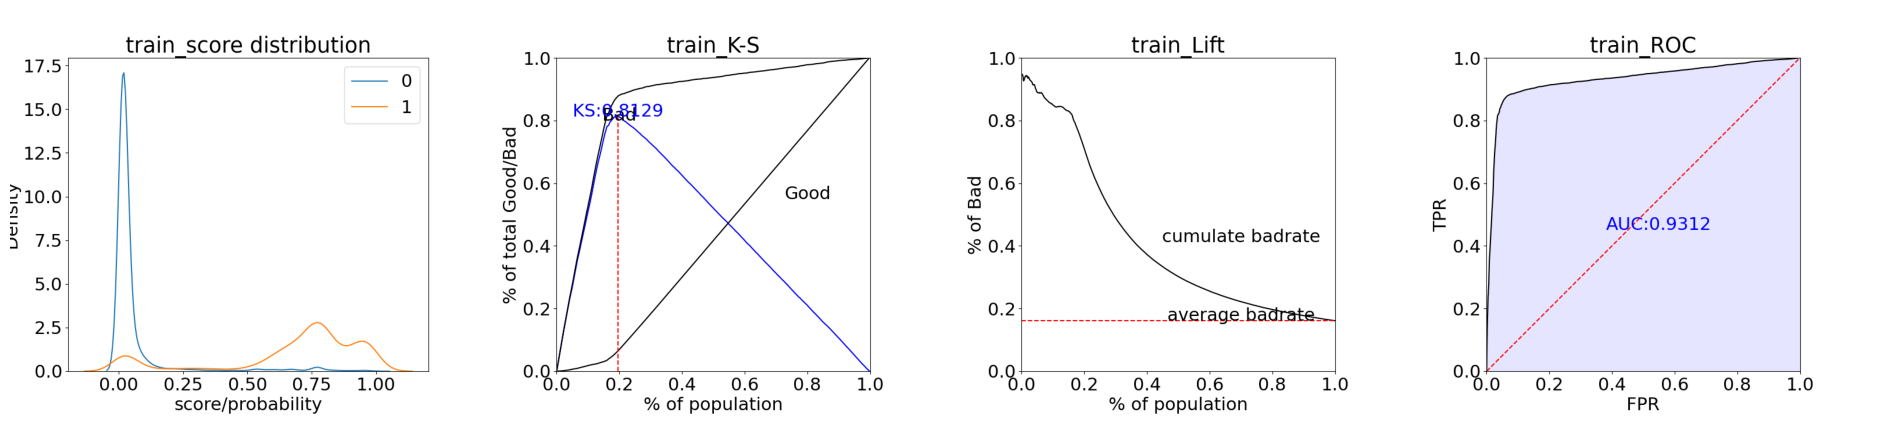

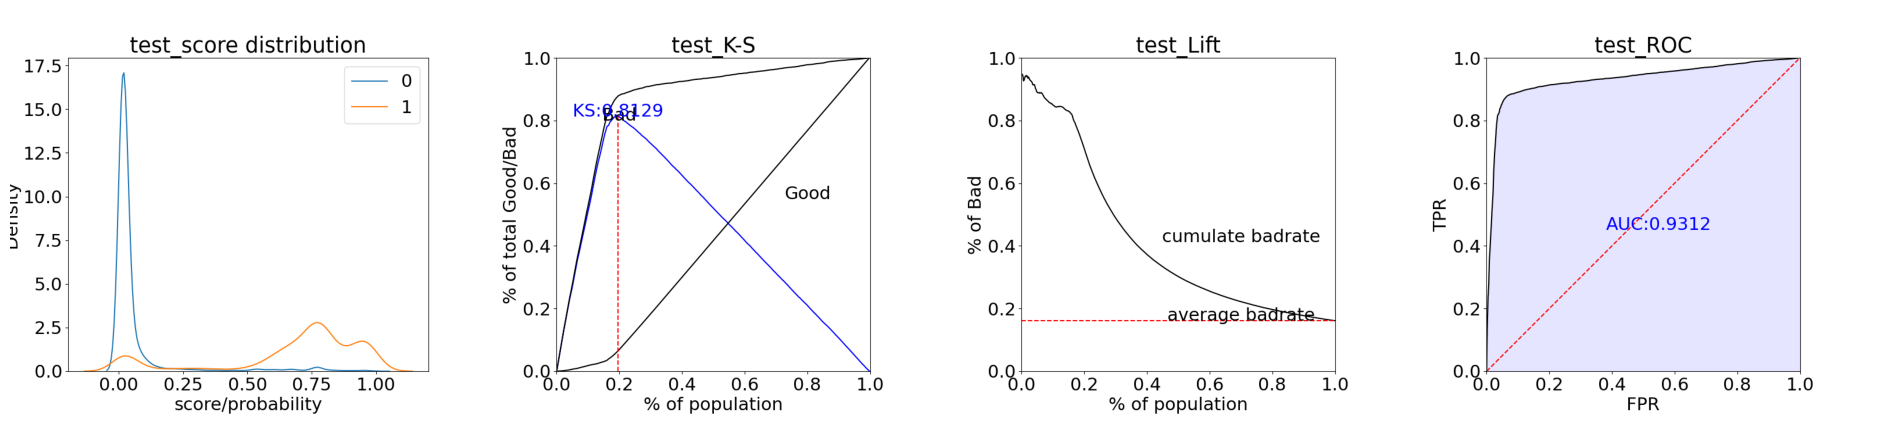

Sample      KS     AUC    GINI      F1  ACCURACY PRECISION  \
阈值是0.0112时的模型表现 0  train  0.8129  0.9312  0.8624  0.3017  25.9484%  17.7929%   
                1   test  0.8129  0.9312  0.8624  0.3017  25.9484%  17.7929%   
阈值是0.013时的模型表现  0  train  0.8129  0.9312  0.8624  0.3262  34.7461%  19.5752%   
                1   test  0.8129  0.9312  0.8624  0.3262  34.7461%  19.5752%   
阈值是0.0161时的模型表现 0  train  0.8129  0.9312  0.8624  0.3608  44.8678%  22.1973%   
                1   test  0.8129  0.9312  0.8624  0.3608  44.8678%  22.1973%   
阈值是0.0185时的模型表现 0  train  0.8129  0.9312  0.8624  0.4049  54.8636%  25.7205%   
                1   test  0.8129  0.9312  0.8624  0.4049  54.8636%  25.7205%   
阈值是0.0224时的模型表现 0  train  0.8129  0.9312  0.8624  0.4582  64.2153%  30.3242%   
                1   test  0.8129  0.9312  0.8624  0.4582  64.2153%  30.3242%   
阈值是0.0267时的模型表现 0  train  0.8129  0.9312  0.8624  0.5321  73.7432%  37.3543%   
                1   test  0.8129  0.9312  0.8624  0.5321  73.7432%  37.3543%   
阈值是0.0441时的模型表现 0  train  0.8129  0.9312  0.8624  0.6382  83.3445%  49.1505%   
                1   test  0.8129  0.9312  0.8624  0.6382  83.3445%  49.1505%   
阈值是0.1609时的模型表现 0  train  0.8129  0.9312  0.8624  0.7867  92.2912%  71.0974%   
                1   test  0.8129  0.9312  0.8624  0.7867  92.2912%  71.0974%   
阈值是0.7624时的模型表现 0  train  0.8129  0.9312  0.8624  0.6493  90.8351%  84.9580%   
                1   test  0.8129  0.9312  0.8624  0.6493  90.8351%  84.9580%   

                     RECALL  
阈值是0.0112时的模型表现 0  99.0515%  
                1  99.0515%  
阈值是0.013时的模型表现  0  97.8300%  
                1  97.8300%  
阈值是0.0161时的模型表现 0  96.3747%  
                1  96.3747%  
阈值是0.0185时的模型表现 0  95.0884%  
                1  95.0884%  
阈值是0.0224时的模型表现 0  93.7110%  
                1  93.7110%  
阈值是0.0267时的模型表现 0  92.4636%  
                1  92.4636%  
阈值是0.0441时的模型表现 0  90.9693%  
                1  90.9693%  
阈值是0.1609时的模型表现 0  88.0587%  
                1  88.0587%  
阈值是0.7624时的模型表现 0  52.5468%  
                1  52.5468%

In [14]:
res = sp.report_model({'train': res_sc, 'test': res_sc.copy()}, target=y_label, pred='score',plot_type=['ks', 'lift', 'roc', 'score_distr'])

In [16]:
sub_sc = res_val[['id']]

sub_sc['score'] = model.predict_proba(res_val[res_data.columns.drop([y_label,'id'])])[:,1]
sub_sc = sub_sc.sort_values(by=['id']).reset_index(drop=True)
sub_sc.head()

,id,score
0,0,0.023767
1,1,0.008923
2,2,0.018195
3,3,0.027816
4,4,0.011476


### null importance特征筛选

In [17]:
feats, categorical_feats = get_null_importance(df_train.drop(columns=[y_label,'id']),
                                               df_train[y_label], 
                                               thresholds=15)

In [18]:

object_feats = ['ip_transform', 'user_name', 'device_num_transform']

df_train = pd.concat([df_train_info[object_feats], df_train[feats], res_data], axis=1)
df_test = pd.concat([df_test[feats], res_val], axis=1)

## modeling

In [19]:

feats = df_train.columns.drop(['id', y_label]+object_feats)
feats = feats.drop(categorical_feats)
#feats 

In [20]:
categorical_feats

['department', 'op_city', 'url', 'url_page']

In [30]:
feats = feats_importance.sort_values('importance', ascending=False)[:20]['name'].values

In [31]:

import time
from sklearn.metrics import roc_auc_score as auc
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold

In [32]:
params = {
    'learning_rate': 0.05,
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'verbose': -1,
    'seed': 2222,
    'n_jobs': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'bagging_freq': 4,
    # 'min_child_weight': 10,
}

In [33]:
fold_num = 5
seeds = [2022]
oof = np.zeros(len(df_train))
importance = 0
pred_y = pd.DataFrame()
score = []
for seed in seeds:
    kf = StratifiedKFold(n_splits=fold_num, shuffle=True, random_state=seed)
    # kf = KFold(n_splits=fold_num, shuffle=True, random_state=seed)
    for fold, (train_idx, val_idx) in enumerate(kf.split(df_train[feats], df_train[y_label])):
        print('-----------', fold)
        train = lgb.Dataset(df_train.loc[train_idx, feats],
                            df_train.loc[train_idx, y_label],
                           # categorical_feature=categorical_feats
                           )
        val = lgb.Dataset(df_train.loc[val_idx, feats],
                          df_train.loc[val_idx, y_label],
                          #categorical_feature=categorical_feats
                         )
        model = lgb.train(params, train, valid_sets=[val], 
                          num_boost_round=20000, early_stopping_rounds=100)

        oof[val_idx] += model.predict(df_train.loc[val_idx, feats]) / len(seeds)
        pred_y['fold_%d_seed_%d' % (fold, seed)] = model.predict(df_test[feats])
        importance += model.feature_importance(importance_type='gain') / fold_num
        score.append(auc(df_train.loc[val_idx, y_label], model.predict(df_train.loc[val_idx, feats])))
feats_importance = pd.DataFrame()
feats_importance['name'] = feats
feats_importance['importance'] = importance
display(feats_importance.sort_values('importance', ascending=False)[:30])

df_train['oof'] = oof
display(np.mean(score), np.std(score))

score = np.mean(score)
df_test[y_label] = pred_y.mean(axis=1).values
df_test = df_test.sort_values('id').reset_index(drop=True)

sub = pd.read_csv(path_sample_submission)
sub[y_label] = df_test[y_label].values
sub.to_csv(os.path.join(path_results_jupyter,time.strftime('lgb_%Y%m%d%H%M_')+'%.5f.csv'%score), index=False)

----------- 0
[1]	valid_0's auc: 0.934798
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.934997
[3]	valid_0's auc: 0.93942
[4]	valid_0's auc: 0.940742
[5]	valid_0's auc: 0.941057
[6]	valid_0's auc: 0.941094
[7]	valid_0's auc: 0.94123
[8]	valid_0's auc: 0.941202
[9]	valid_0's auc: 0.941749
[10]	valid_0's auc: 0.941664
[11]	valid_0's auc: 0.942158
[12]	valid_0's auc: 0.942188
[13]	valid_0's auc: 0.942031
[14]	valid_0's auc: 0.942106
[15]	valid_0's auc: 0.942208
[16]	valid_0's auc: 0.942222
[17]	valid_0's auc: 0.942651
[18]	valid_0's auc: 0.942618
[19]	valid_0's auc: 0.943231
[20]	valid_0's auc: 0.943065
[21]	valid_0's auc: 0.943073
[22]	valid_0's auc: 0.943285
[23]	valid_0's auc: 0.943316
[24]	valid_0's auc: 0.943256
[25]	valid_0's auc: 0.943275
[26]	valid_0's auc: 0.943292
[27]	valid_0's auc: 0.94315
[28]	valid_0's auc: 0.943125
[29]	valid_0's auc: 0.943179
[30]	valid_0's auc: 0.943207
[31]	valid_0's auc: 0.943173
[32]	valid_0's auc: 0.942783
[33]	val

[108]	valid_0's auc: 0.940659
[109]	valid_0's auc: 0.94067
[110]	valid_0's auc: 0.940701
[111]	valid_0's auc: 0.940823
[112]	valid_0's auc: 0.940822
[113]	valid_0's auc: 0.940863
[114]	valid_0's auc: 0.940754
[115]	valid_0's auc: 0.940543
[116]	valid_0's auc: 0.940753
[117]	valid_0's auc: 0.940694
[118]	valid_0's auc: 0.940671
[119]	valid_0's auc: 0.940591
[120]	valid_0's auc: 0.940507
[121]	valid_0's auc: 0.940565
[122]	valid_0's auc: 0.940545
[123]	valid_0's auc: 0.940465
[124]	valid_0's auc: 0.940454
[125]	valid_0's auc: 0.940661
[126]	valid_0's auc: 0.940495
[127]	valid_0's auc: 0.940356
[128]	valid_0's auc: 0.940188
[129]	valid_0's auc: 0.94048
[130]	valid_0's auc: 0.9406
[131]	valid_0's auc: 0.94062
[132]	valid_0's auc: 0.940672
[133]	valid_0's auc: 0.940852
[134]	valid_0's auc: 0.940943
[135]	valid_0's auc: 0.940837
[136]	valid_0's auc: 0.941002
[137]	valid_0's auc: 0.94107
[138]	valid_0's auc: 0.941065
[139]	valid_0's auc: 0.94116
[140]	valid_0's auc: 0.941124
[141]	valid_0's a

[16]	valid_0's auc: 0.937822
[17]	valid_0's auc: 0.937793
[18]	valid_0's auc: 0.937743
[19]	valid_0's auc: 0.938388
[20]	valid_0's auc: 0.93827
[21]	valid_0's auc: 0.938315
[22]	valid_0's auc: 0.938319
[23]	valid_0's auc: 0.938367
[24]	valid_0's auc: 0.938454
[25]	valid_0's auc: 0.938494
[26]	valid_0's auc: 0.938665
[27]	valid_0's auc: 0.938582
[28]	valid_0's auc: 0.938488
[29]	valid_0's auc: 0.938597
[30]	valid_0's auc: 0.93863
[31]	valid_0's auc: 0.938764
[32]	valid_0's auc: 0.938759
[33]	valid_0's auc: 0.939121
[34]	valid_0's auc: 0.939138
[35]	valid_0's auc: 0.93951
[36]	valid_0's auc: 0.940314
[37]	valid_0's auc: 0.939906
[38]	valid_0's auc: 0.93949
[39]	valid_0's auc: 0.939461
[40]	valid_0's auc: 0.939517
[41]	valid_0's auc: 0.939582
[42]	valid_0's auc: 0.940113
[43]	valid_0's auc: 0.939954
[44]	valid_0's auc: 0.940246
[45]	valid_0's auc: 0.940006
[46]	valid_0's auc: 0.940017
[47]	valid_0's auc: 0.940846
[48]	valid_0's auc: 0.941147
[49]	valid_0's auc: 0.941091
[50]	valid_0's auc

,name,importance
0,system_system_op_times_groups_http_status_code...,75315.463897
2,op_month_ip_transform_cumsum,27070.662936
1,system_op_days_http_status_code_200_cumsum,26749.550276
3,op_times_groups_ip_transform_cumsum,19774.007623
4,op_diff_second1,9928.795383
6,hour,9576.983015
5,op_month_ip_transform_cumsum_woe,7084.195660
8,system_system_op_times_groups_cumsum,6787.078843
7,op_times_groups_device_num_transform_cumsum,4619.909411
9,hour_cos,3802.788354


0.9423363738675891

0.0016178668239629692

In [34]:
feats_importance.sort_values('importance', ascending=False)[:50]

,name,importance
0,system_system_op_times_groups_http_status_code...,75315.463897
2,op_month_ip_transform_cumsum,27070.662936
1,system_op_days_http_status_code_200_cumsum,26749.550276
3,op_times_groups_ip_transform_cumsum,19774.007623
4,op_diff_second1,9928.795383
6,hour,9576.983015
5,op_month_ip_transform_cumsum_woe,7084.195660
8,system_system_op_times_groups_cumsum,6787.078843
7,op_times_groups_device_num_transform_cumsum,4619.909411
9,hour_cos,3802.788354


In [35]:
feats_importance.sort_values('importance', ascending=False)[:50].name.values

array(['system_system_op_times_groups_http_status_code_200_cumsum',
       'op_month_ip_transform_cumsum',
       'system_op_days_http_status_code_200_cumsum',
       'op_times_groups_ip_transform_cumsum', 'op_diff_second1', 'hour',
       'op_month_ip_transform_cumsum_woe',
       'system_system_op_times_groups_cumsum',
       'op_times_groups_device_num_transform_cumsum', 'hour_cos',
       'system_system_op_times_groups_ip_type_内网_cumsum',
       'system_op_days_ip_type_内网_cumsum',
       'op_times_groups_user_name_cumsum',
       'op_days_device_num_transform_cumsum',
       'system_op_days_department_rd_cumsum',
       'system_system_op_times_groups_department_rd_cumsum',
       'op_times_groups',
       'system_system_op_times_groups_department_sales_cumsum',
       'system_op_days_log_system_transform_nHrKgKdJ1Mzt_cumsum',
       'system_op_month_http_status_code_200_cumsum_woe'], dtype=object)

In [ ]:
df_train_info['oof']=df_train['oof']

df_train_info[abs(df_train_info['is_risk']-df_train_info['oof'])>0.7]['device_num_transform'].value_counts()

In [ ]:
df_train_info[df_train_info['device_num_transform']=='0dV6LzVsv7pW']

In [36]:
sub_merge = pd.concat([sub,sub_sc['score']], axis=1)
sub_final = sub_merge[['id']]
sub_final['is_risk'] = 0.9423363738675891/(0.9423363738675891+0.9312)*sub_merge['is_risk'] + 0.9312/(0.9423363738675891+0.9312)*sub_merge['score']
sub_final.head()

,id,is_risk
0,0,0.035318
1,1,0.022545
2,2,0.034020
3,3,0.030858
4,4,0.024617


In [37]:

sub_final.to_csv(os.path.join(path_results_jupyter,time.strftime('lgb_sc_%Y%m%d%H%M')+'.csv'), index=False)

In [ ]:
sub_final.tail()